In [1]:
import numpy as np
from matplotlib import pyplot as plt
import json, math

In [2]:
# read histogram from json file
with open('hist.json') as f:
    ys, vs = json.load(f) # weights and variances (σ²)

step = (160-105)/len(ys)
xs = np.linspace(105+step/2 - 125, 160-step/2 - 125, len(ys))

# get rid of bins with non-positive weight
bad = np.nonzero(np.asarray(ys) <= 0)[0]

if len(bad) > 0:
    print("Skipped bins:")
    for i in bad:
        print(i,xs[i],ys[i])
    xs = np.delete(xs,bad)
    ys = np.delete(ys,bad)
    vs = np.delete(vs,bad)

us = np.sqrt(vs)

# logarithmic scale
us = us/ys
vs = us**2
ys = np.log(ys)

Skipped bins:
195 28.875 -2.3451795598816716e-06


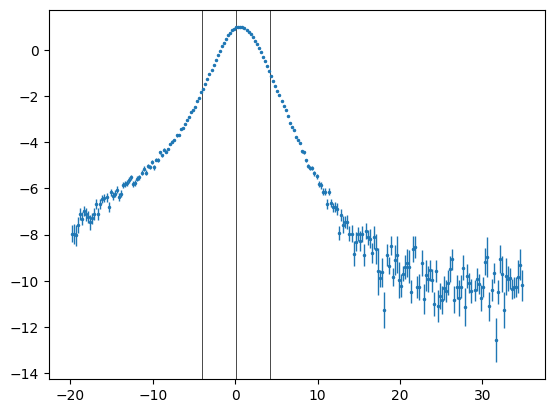

In [3]:
# Identify signal region
core = np.searchsorted(xs,[-4,0,4],side='right')
# Make sure there are at least 3 bins
if core[1] == core[0]:
    core[1] -= 1
if core[2] == core[0]:
    core[2] += 1

plt.errorbar(xs,ys,yerr=us,linestyle='',marker='.',linewidth=1,markersize=3)
plt.axvline(xs[core[0]]-step/2, linewidth = 0.5, color = 'k')
plt.axvline(xs[core[1]], linewidth = 0.5, color = 'k')
plt.axvline(xs[core[2]]+step/2, linewidth = 0.5, color = 'k')
None

In [4]:
# linear least squares fit for second degree polynomial
def fit_core(a,b):
    if b < a:
        a,b = b,a
    b += 1 # [a,b]

    A = np.asarray([ [
        1.,
        x,
        x*x
    ] for x in xs[a:b] ])

    At = np.transpose(A)

    Vi = np.linalg.inv(np.diag(vs[a:b])) # V^-1

    AtVi = np.dot(At,Vi)

    B = np.dot(np.linalg.inv(np.dot(AtVi,A)),AtVi)

    c = np.dot(B,ys[a:b]) # optimized parameters

    return (
        c,
        np.sum( (ys[a:b]-np.dot(A,c))**2 / vs[a:b] )/(b-a) # χ²/N
    )

[ 0.909137    0.1679025  -0.15457079]
χ²/N = 82.59265760221123


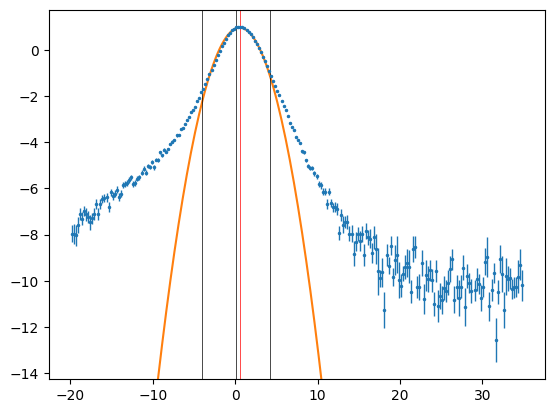

In [5]:
c, χ2 = fit_core(core[0],core[2])
x_peak = -c[1]/(2*c[2])

plt.errorbar(
    xs,ys,yerr=us,
    linestyle='',marker='.',linewidth=1,markersize=3
)
ymin, ymax = plt.ylim()
plt.plot(
    xs,c[0]+xs*c[1]+xs*xs*c[2],
    linestyle='-',marker='',linewidth=1.5
)
plt.ylim(ymin, ymax)
plt.axvline(x_peak, linewidth=0.5, color='r')
plt.axvline(xs[core[0]]-step/2, linewidth = 0.5, color = 'k')
plt.axvline(xs[core[1]], linewidth = 0.5, color = 'k')
plt.axvline(xs[core[2]]+step/2, linewidth = 0.5, color = 'k')
print(c)
print(f'χ²/N = {χ2}')

In [6]:
# find the closest bin center to the fitted peak
i_peak = np.searchsorted(xs,x_peak,side='right')
if x_peak - xs[i_peak-1] < xs[i_peak] - x_peak:
    i_peak -= 1
i_peak += np.argmax(ys[[i_peak-1,i_peak,i_peak+1]]) - 1
print(xs[i_peak-1:i_peak+2])

[0.125 0.375 0.625]


In [7]:
χ2_both = [
    fit_core(i_peak-i,i_peak+i)[1]
    for i in np.arange(1,21)
]
for i,x in enumerate(χ2_both):
    print(i+1,x)

1 5.959720973803078e-24
2 0.8711785897232005
3 0.7357404964772539
4 0.667473150318978
5 0.8488616439517179
6 0.7502152607690683
7 1.058615822051377
8 1.4932311920960257
9 2.9483933946867653
10 5.486081395397626
11 9.462395857609598
12 16.94342455334169
13 24.31395204668991
14 40.32291984945125
15 55.167390222195785
16 72.58969664007729
17 91.93527596882029
18 117.54825817658373
19 139.7353281435324
20 170.5286039767431


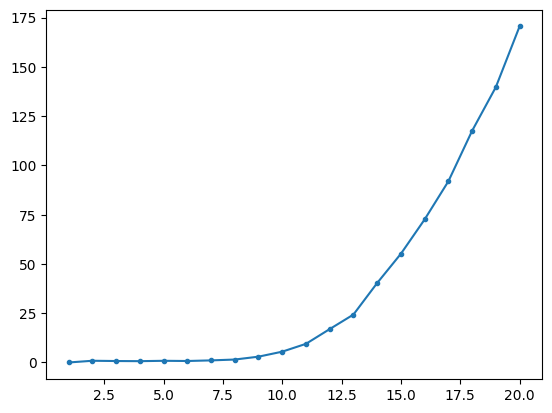

In [8]:
plt.plot(
    np.arange(1,21),
    χ2_both,
    linestyle='-',marker='.',linewidth=1.5
)
None

We want to extend the Gaussian core as wide as we can, but not too far.
Because the tails are wider, if we extend too far, the best fit will be too high closer to the center and too low out in the tails.
This can be quantified by looking at the χ²/N as a function of the core region width. When the core region is extended too far, the χ²/N becomes large.

The plot below, illustrates what overly wide core fit looks like.

[ 0.7463843   0.07340664 -0.08864489]
χ²/N = 1132.405252854334


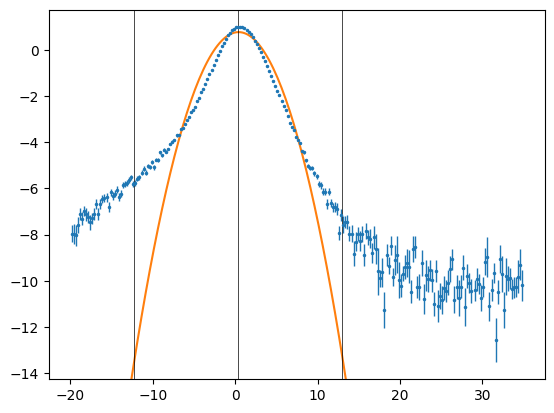

In [9]:
c, χ2 = fit_core(i_peak-50,i_peak+50)

plt.errorbar(
    xs,ys,yerr=us,
    linestyle='',marker='.',linewidth=1,markersize=3
)
ymin, ymax = plt.ylim()
plt.plot(
    xs,c[0]+xs*c[1]+xs*xs*c[2],
    linestyle='-',marker='',linewidth=1.5
)
plt.ylim(ymin, ymax)
plt.axvline(xs[i_peak], linewidth=0.5, color='k')
plt.axvline(xs[i_peak-50]-step/2, linewidth=0.5, color='k')
plt.axvline(xs[i_peak+50]+step/2, linewidth=0.5, color='k')
print(c)
print(f'χ²/N = {χ2}')

From the χ²/N as a function of N plot above, 10 bin on either size of the peak appears to be a decent choise.
The figure below illustrates the fit performed using that region.

[ 0.93607978  0.19274824 -0.17734736]
χ²/N = 5.486081395397626


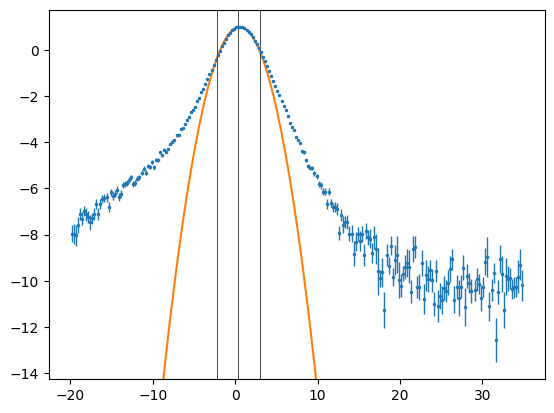

In [10]:
n_left = 10
n_right = 10

c, χ2 = fit_core(i_peak-n_left,i_peak+n_right)

plt.errorbar(
    xs,ys,yerr=us,
    linestyle='',marker='.',linewidth=1,markersize=3
)
ymin, ymax = plt.ylim()
plt.plot(
    xs,c[0]+xs*c[1]+xs*xs*c[2],
    linestyle='-',marker='',linewidth=1.5
)
plt.ylim(ymin, ymax)
plt.axvline(xs[i_peak], linewidth=0.5, color='k')
plt.axvline(xs[i_peak-n_left]-step/2, linewidth=0.5, color='k')
plt.axvline(xs[i_peak+n_right]+step/2, linewidth=0.5, color='k')
print(c)
print(f'χ²/N = {χ2}')

Let's investigate if there's any asymmetry in how far we can extend the left and right tails independently.

In [11]:
χ2_left = [
    fit_core(i_peak-i,i_peak+n_right)[1]
    for i in np.arange(1,21)
]
for i,x in enumerate(χ2_left):
    print(i+1,x)

1 2.1394453513570313
2 3.4167397068668253
3 3.902918587023128
4 4.218482906508697
5 4.066180117050456
6 4.362451352087366
7 4.638693201182992
8 4.432053632986959
9 4.463026623558576
10 5.486081395397626
11 6.914307952440556
12 11.669718026836671
13 18.068533663439847
14 32.90276089110371
15 48.878908626181264
16 67.35003038474986
17 89.18112900028278
18 119.2260651062159
19 144.17796783410142
20 179.72027793764374


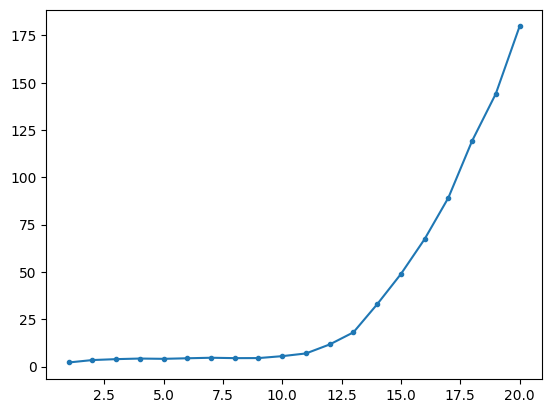

In [12]:
plt.plot(
    np.arange(1,21),
    χ2_left,
    linestyle='-',marker='.',linewidth=1.5
)
None

We can maybe extend the left side of the core to 11 bins.
Let's now look at the right hand side.

In [13]:
χ2_right = [
    fit_core(i_peak-11,i_peak+i)[1]
    for i in np.arange(1,21)
]
for i,x in enumerate(χ2_right):
    print(i+1,x)

1 4.777194743362821
2 5.382575001738097
3 6.341071437455622
4 6.809778566275142
5 6.917860274069417
6 6.977368334002131
7 6.640111581127123
8 6.353204185198232
9 6.343938519103896
10 6.914307952440556
11 9.462395857609598
12 14.300931478851608
13 19.3882627125104
14 29.497401812546723
15 39.417401263114186
16 52.54488632531708
17 66.79746489134008
18 83.67231183993471
19 101.96424275278561
20 123.72812584271094


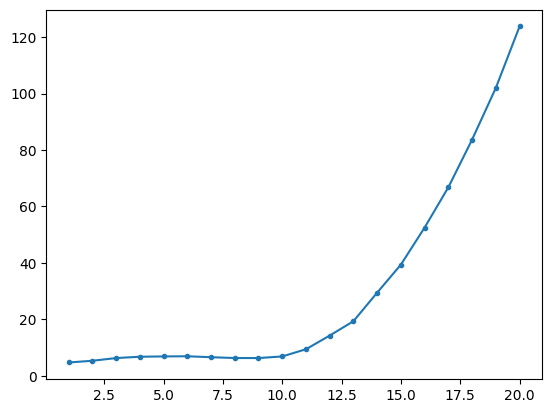

In [14]:
plt.plot(
    np.arange(1,21),
    χ2_right,
    linestyle='-',marker='.',linewidth=1.5
)
None

Looks like the ride side of the core region should be kept at 10 bins.

[70, 81, 91]
[ 0.93526438  0.19008058 -0.17580941]
χ²/N = 6.914307952440556


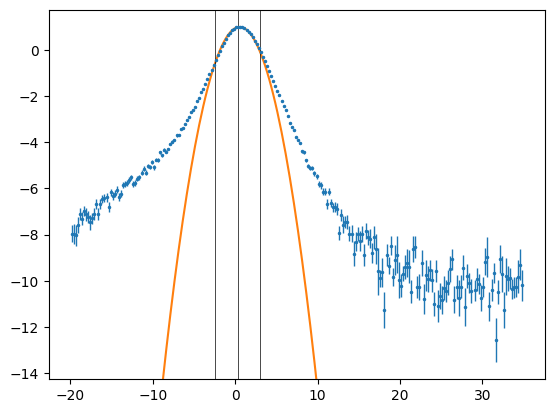

In [17]:
n_left = 11
n_right = 10

c, χ2 = fit_core(i_peak-n_left,i_peak+n_right)

plt.errorbar(
    xs,ys,yerr=us,
    linestyle='',marker='.',linewidth=1,markersize=3
)
ymin, ymax = plt.ylim()
plt.plot(
    xs,c[0]+xs*c[1]+xs*xs*c[2],
    linestyle='-',marker='',linewidth=1.5
)
plt.ylim(ymin, ymax)
plt.axvline(xs[i_peak], linewidth=0.5, color='k')
plt.axvline(xs[i_peak-n_left]-step/2, linewidth=0.5, color='k')
plt.axvline(xs[i_peak+n_right]+step/2, linewidth=0.5, color='k')
print([i_peak-n_left,i_peak,i_peak+n_right])
print(c)
print(f'χ²/N = {χ2}')